In [1]:
import sys
sys.path.append('.')

In [2]:
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import math
import importlib
from torch.utils.data import DataLoader
from lib.datamodule import PressurePoseDataModule, BodiesAtRestDataModule, SLPDataModule, SoftlineDataModule
from lib.F import mpjpe, per_joint_mean_position_errors, per_joint_position_errors, pcp, per_part_correct_percentage, pck, per_keypoint_correct_percentage
from lib.viz import plot_results, plot_mattress
from lib.transforms import SkeletonCleverToCommon, SkeletonSLPToCommon
from lib.constants import constants
import random 

In [3]:
LOG_FOLDER = "tb_logs"
MODEL = "simple-cnn"
VERSION = "version_0"
CHECKPOINT = "best.ckpt"
SET = 'test'

In [4]:
simple_cnn = importlib.import_module("simple-cnn")
net = simple_cnn.Net.load_from_checkpoint(f"{LOG_FOLDER}/{MODEL}/{VERSION}/checkpoints/{CHECKPOINT}")
net

Net(
  (net): Sequential(
    (0): Dropout(p=0.21093740280701387, inplace=False)
    (1): Conv2d(2, 128, kernel_size=(7, 7), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.04039388469612025, inplace=False)
    (5): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
    (6): ReLU()
    (7): Dropout(p=0.036542891208126344, inplace=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): Dropout(p=0.018930763782454747, inplace=False)
    (11): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (12): ReLU()
    (13): Dropout(p=0.03793207249374335, inplace=False)
    (14): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (15): ReLU()
    (16): Flatten()
    (17): Linear(in_features=2048, out_features=26, bias=True)
  )
)

In [5]:
def evaluate():
    global net, dm, X, y, y_hat
    dm.setup()
    val_data = next(iter(DataLoader(dm.test_set if SET == 'test' else dm.val_set, batch_size=len(dm.val_set))))
    X = val_data[0]
    y = val_data[1]
    y_hat = net(X).detach()

In [6]:
JOINT_REMAPPING = [12, 9, 8, 3, 2, 4, 1, 5, 0, 10, 7, 11, 6]
PART_REMAPPING = [2, 1, 3, 0, 6, 5, 7, 4]

In [7]:
def print_metrics():
    global y, y_hat
    pjpe = per_joint_position_errors(y_hat, y)
    print(f"Mean per-joint position error: {mpjpe(y_hat, y)} cm ± {torch.std(pjpe)} cm")
    print(f"PCP: {pcp(y_hat, y)*100} %")
    print(f"PCK: {pck(y_hat, y)*100} %")
    pjmpe = per_joint_mean_position_errors(y_hat, y)
    for index in range(constants.JOINTS):
        i = JOINT_REMAPPING[index]
        print(f"Mean position error for {constants.LABELS[i]}: {pjmpe[i]} cm ± {torch.std(pjpe[i])} cm")
    ppcp = per_part_correct_percentage(y_hat, y)
    for index in range(len(constants.PARTS)):
        i = PART_REMAPPING[index]
        print(f"Percentage of correct {constants.PARTS[i]}s: {ppcp[i]*100} %")
    pkcp = per_keypoint_correct_percentage(y_hat, y)
    for index in range(constants.JOINTS):
        i = JOINT_REMAPPING[index]
        print(f"Percentage of correct {constants.LABELS[i]}s: {pkcp[i]*100} %")

In [8]:
def plot_examples():
    global X, y, y_hat
    
    plt.rcParams.update({'font.size': 12})
    fig, axes = plt.subplots(3, 5)
    fig.set_size_inches(20, 20)
    
    random.seed(4242)
    for i in range(3):
        for j in range(5):
            index = int(random.random()*256) % len(X) # 3*i+j
            plot_results(
                X[index][0],
                [y[index].reshape(-1,2), y_hat[index].reshape(-1,2)],
                ax=axes[i][j]
            )

In [9]:
def plot_per_joint_position_errors():
    global y, y_hat
    errors = per_joint_position_errors(y_hat, y)

    plt.rcParams.update({'font.size': 30})
    fig, axes = plt.subplots(2, 7)
    fig.set_size_inches(40, 10)

    for i in range(2):
        for j in range(7):
            index = 7*i+j
            if index >= constants.JOINTS:
                break
            index = JOINT_REMAPPING[index]
            sns.kdeplot(errors[index].numpy(), ax=axes[i][j], fill=True)
            axes[i][j].set_title(constants.LABELS[index])
            axes[i][j].tick_params(left=False, labelleft=False, labelbottom=False)
            axes[i][j].set_ylabel(None)
    sns.kdeplot(errors.reshape(-1).numpy(), ax=axes[1][6], fill=True)
    axes[1][6].set_title('Overall')
    axes[1][6].tick_params(labelleft=False, labelbottom=False)
    axes[1][6].set_ylabel(None)
    plt.setp(axes, xlim=(0, 50), xticks=(0, 50), ylim=(0, 0.25))

# Validation Dataset

In [10]:
dm = PressurePoseDataModule()
evaluate()

In [11]:
print_metrics()

Mean per-joint position error: 8.634757002666337 cm ± 8.048173377233605 cm
PCP: 78.75926208496094 %
PCK: 78.63247680664062 %
Mean position error for Thorax: 4.189092669016108 cm ± 2.638415220921957 cm
Mean position error for Left shoulder: 6.341447533365905 cm ± 4.167047793803773 cm
Mean position error for Right shoulder: 6.367999494347462 cm ± 4.237482760743732 cm
Mean position error for Left hip: 4.548842755607357 cm ± 2.7570540310363865 cm
Mean position error for Right hip: 4.839561937529881 cm ± 3.01928119106943 cm
Mean position error for Left knee: 6.852568861327664 cm ± 5.433524512658455 cm
Mean position error for Right knee: 7.582216236990084 cm ± 6.523933728105104 cm
Mean position error for Left ankle: 8.763730532858537 cm ± 7.5386196820824765 cm
Mean position error for Right ankle: 8.733077620596447 cm ± 7.311214496917079 cm
Mean position error for Left elbow: 10.053793612122377 cm ± 8.778967241456533 cm
Mean position error for Right elbow: 10.667228260857806 cm ± 9.0180002352

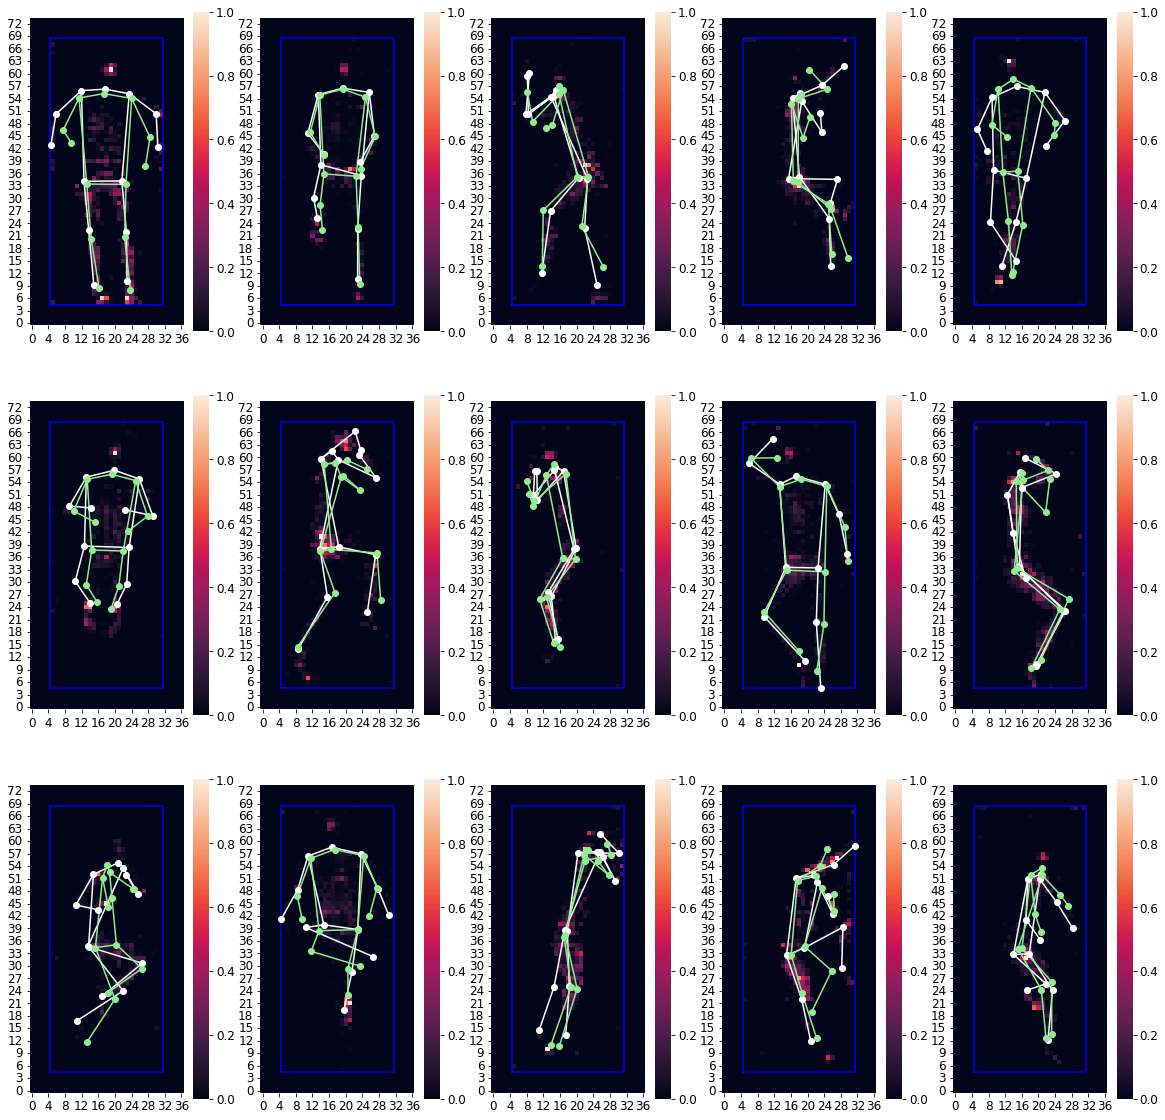

In [12]:
plot_examples()

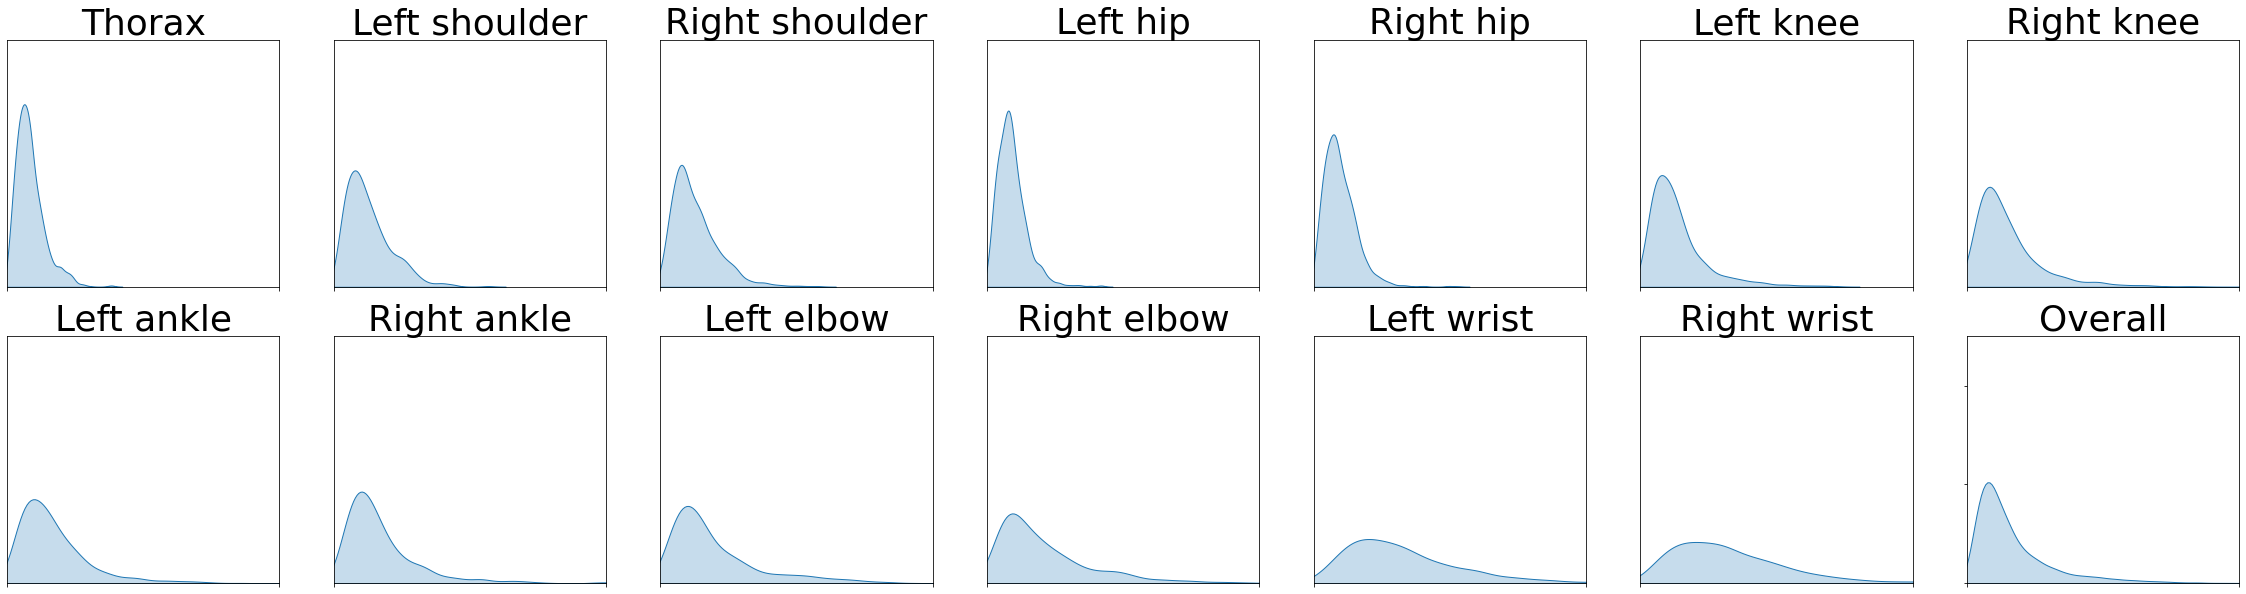

In [13]:
plot_per_joint_position_errors()

# Bodies-at-Rest Dataset

In [14]:
dm = BodiesAtRestDataModule(target_transform=SkeletonCleverToCommon())
evaluate()

In [15]:
print_metrics()

Mean per-joint position error: 10.632804199182928 cm ± 12.32946109784371 cm
PCP: 75.48491668701172 %
PCK: 72.2652587890625 %
Mean position error for Thorax: 4.218520658117184 cm ± 2.8812811931890714 cm
Mean position error for Left shoulder: 4.580683847419317 cm ± 3.140169139864188 cm
Mean position error for Right shoulder: 4.5349741114010955 cm ± 3.0563579538137158 cm
Mean position error for Left hip: 3.101483625182737 cm ± 2.0823345163628266 cm
Mean position error for Right hip: 3.15402303061109 cm ± 2.052240353384384 cm
Mean position error for Left knee: 7.860507168006957 cm ± 6.50307691711884 cm
Mean position error for Right knee: 7.661430135663268 cm ± 6.483891916898925 cm
Mean position error for Left ankle: 14.064394430197694 cm ± 12.738475379047781 cm
Mean position error for Right ankle: 14.04186006188068 cm ± 13.397949305484714 cm
Mean position error for Left elbow: 14.088036948003335 cm ± 11.040068670567878 cm
Mean position error for Right elbow: 13.667908692652887 cm ± 10.8223

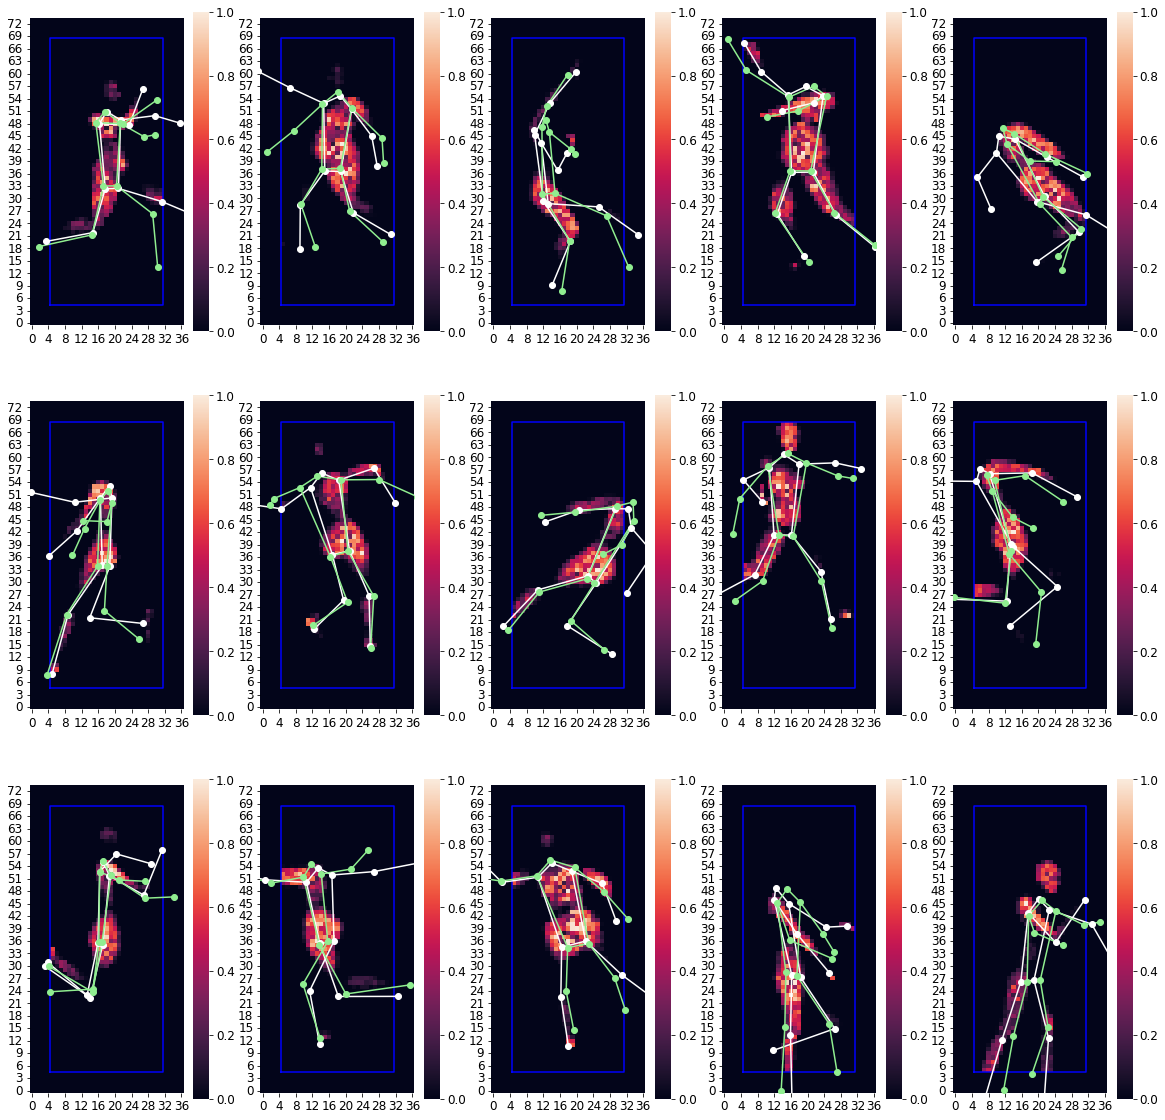

In [16]:
plot_examples()

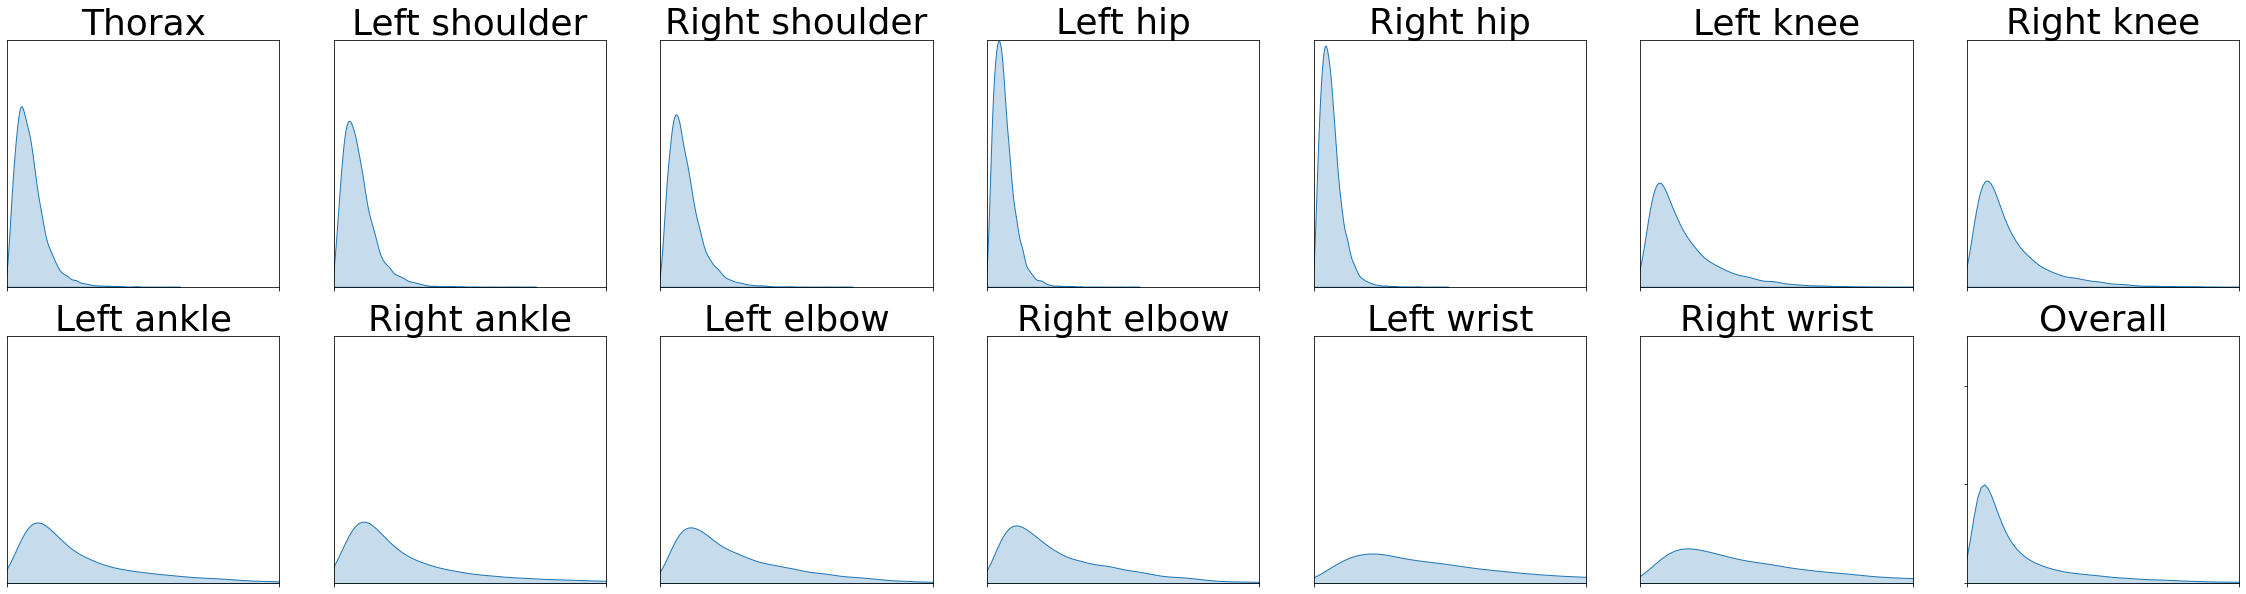

In [17]:
plot_per_joint_position_errors()

# SLP Dataset

In [18]:
dm = SLPDataModule(target_transform=SkeletonSLPToCommon())
evaluate()

In [19]:
print_metrics()

Mean per-joint position error: 8.790112113004161 cm ± 8.183110669579337 cm
PCP: 78.11111450195312 %
PCK: 77.93732452392578 %
Mean position error for Thorax: 4.175160053762775 cm ± 2.7139627036369895 cm
Mean position error for Left shoulder: 6.33279960596973 cm ± 4.164373929643346 cm
Mean position error for Right shoulder: 6.248714731377627 cm ± 4.058644600894977 cm
Mean position error for Left hip: 4.611061733993433 cm ± 2.7262250450484475 cm
Mean position error for Right hip: 4.895104584052378 cm ± 3.034871630143773 cm
Mean position error for Left knee: 7.168327536829888 cm ± 5.649896969326611 cm
Mean position error for Right knee: 7.8473216188568635 cm ± 6.756436993330585 cm
Mean position error for Left ankle: 9.092417413272615 cm ± 8.001223166624767 cm
Mean position error for Right ankle: 9.121338820481947 cm ± 7.506493433639523 cm
Mean position error for Left elbow: 10.20178439983537 cm ± 8.9121427622837 cm
Mean position error for Right elbow: 10.948044139106509 cm ± 9.173966674928

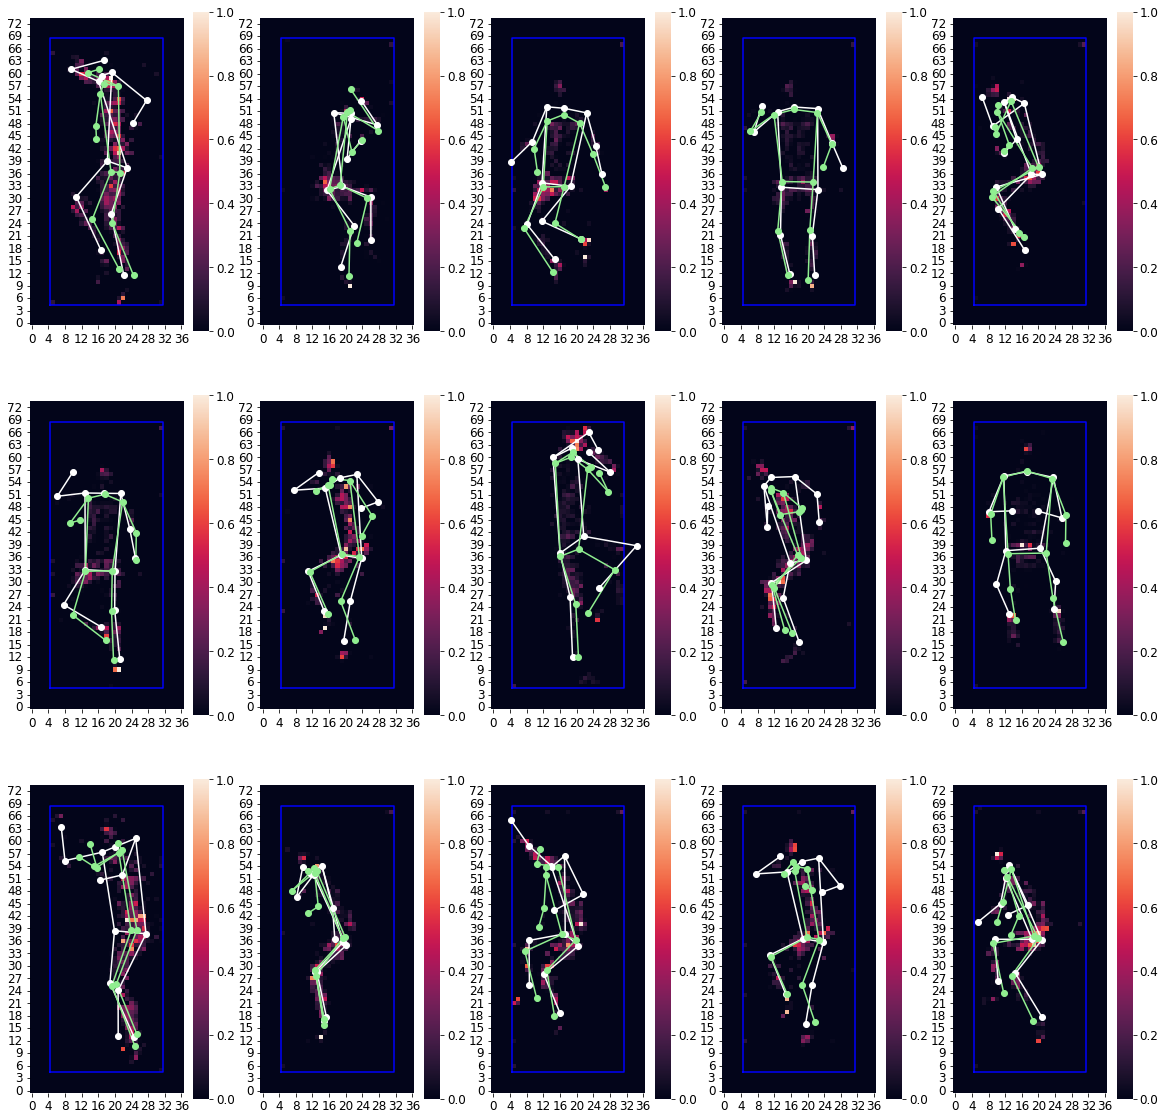

In [20]:
plot_examples()

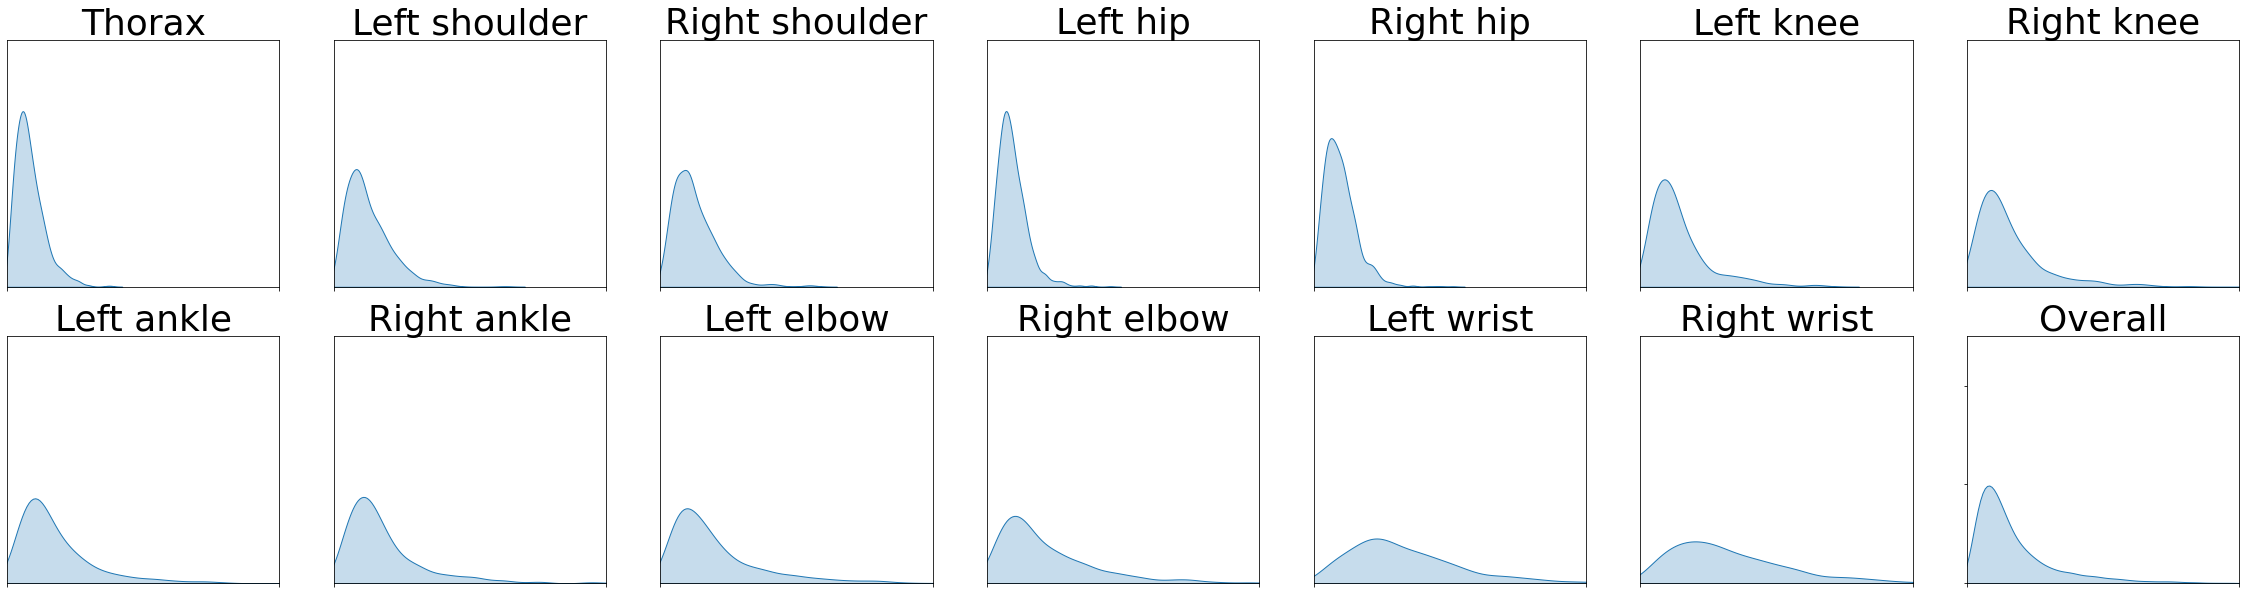

In [21]:
plot_per_joint_position_errors()

# Softline dataset

In [22]:
dm = SoftlineDataModule()
evaluate()

In [23]:
print_metrics()

Mean per-joint position error: 14.927422837886919 cm ± 10.866694282898168 cm
PCP: 65.5 %
PCK: 47.384613037109375 %
Mean position error for Thorax: 5.011120151276111 cm ± 3.0376325016156898 cm
Mean position error for Left shoulder: 9.474202376407487 cm ± 5.710457370658865 cm
Mean position error for Right shoulder: 6.978062719660022 cm ± 3.7119294480202334 cm
Mean position error for Left hip: 11.279609430947595 cm ± 3.974288581577779 cm
Mean position error for Right hip: 11.098458656832584 cm ± 4.056392739863124 cm
Mean position error for Left knee: 14.429639991369049 cm ± 7.373703338929321 cm
Mean position error for Right knee: 13.156819319365972 cm ± 7.853595733094068 cm
Mean position error for Left ankle: 12.13824196616954 cm ± 6.625475235558878 cm
Mean position error for Right ankle: 14.677606253490938 cm ± 8.207417448002753 cm
Mean position error for Left elbow: 17.17664816455264 cm ± 10.045298809411115 cm
Mean position error for Right elbow: 21.033342650957884 cm ± 12.5362780375907

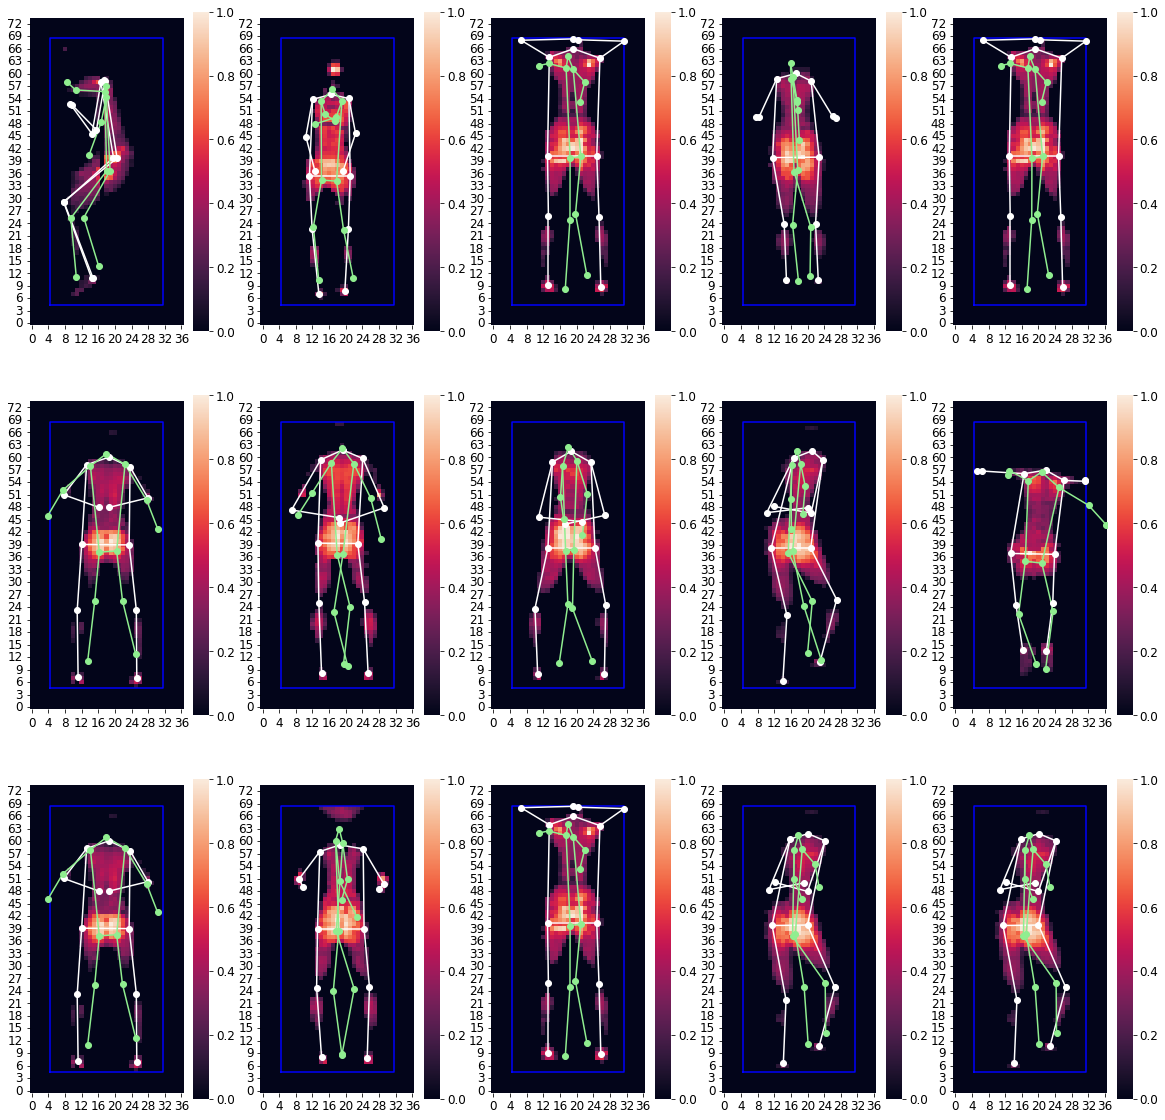

In [24]:
plot_examples()

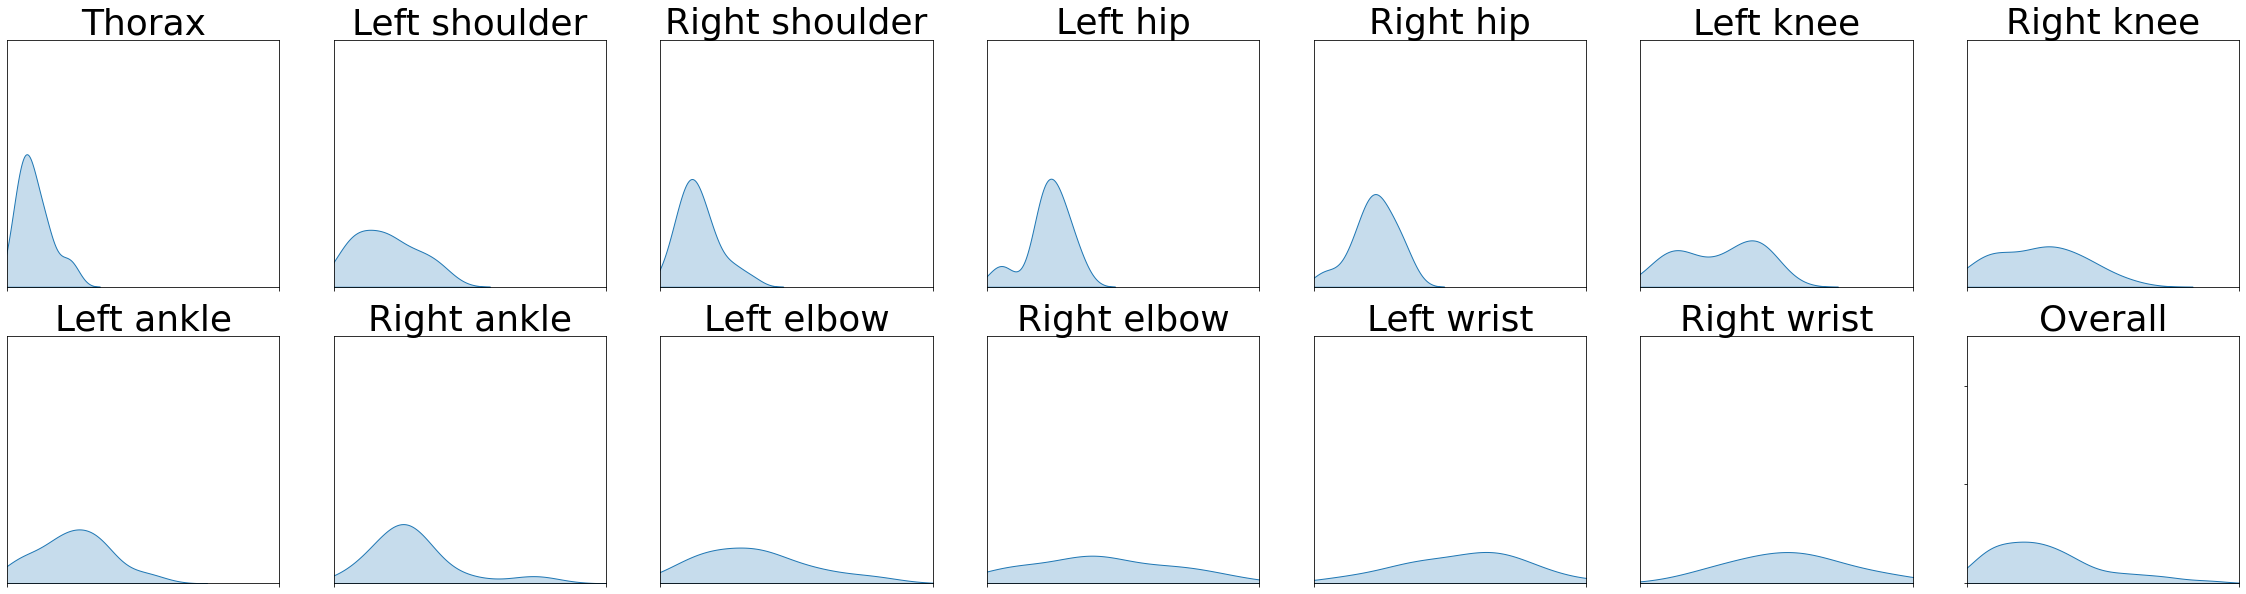

In [25]:
plot_per_joint_position_errors()